In [21]:
!pip install numpy
!pip install --upgrade --force-reinstall mediapipe opencv-python matplotlib

  Using cached mediapipe-0.10.21-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached jax-0.7.2-py3-none-any.whl.metadata (13 kB)
  Using cached jaxlib-0.7.2-cp312-cp312-manylinux_2_27_x86_64.whl.metadata (1.3 kB)
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached opencv_contrib_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached protobuf-4.25.8-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached sounddevice-0.5.

In [22]:
import cv2
import numpy as np
import mediapipe as mp
from matplotlib import pyplot as plt

In [23]:
# IMAGE PATHS
img1_path = "/content/face1.jpg"   # low-frequency image
img2_path = "/content/face2.jpg"   # high-frequency image

In [24]:
# Helpers
def load_color(path):
    img_bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if img_bgr is None:
        raise FileNotFoundError(f"Cannot load image: {path}")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb

def to_gray_uint8(img_rgb):
    return cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

In [25]:
# Add border points to keep whole image in triangulation
def add_boundary_points(pts, w, h):
    boundary = [
        (0,0), (w//2, 0), (w-1, 0),
        (0, h//2), (w-1, h//2),
        (0, h-1), (w//2, h-1), (w-1, h-1)
    ]
    for p in boundary:
        if 0 <= p[0] < w and 0 <= p[1] < h and p not in pts:
            pts.append(p)
    return pts

# Find index of point in list by nearest match
def find_nearest_index(points, coord, tol=5):
    cx, cy = coord
    for i, (x,y) in enumerate(points):
        if (abs(int(x)-int(cx)) <= tol) and (abs(int(y)-int(cy)) <= tol):
            return i
    dists = [ (i, (x-cx)**2 + (y-cy)**2) for i,(x,y) in enumerate(points) ]
    if dists:
        i_min, dist_min = min(dists, key=lambda z: z[1])
        return i_min if dist_min < (tol*tol*2) else None
    return None

In [26]:
# Build triangle indices by matching coordinates to original points
def get_triangles_from_subdiv(points, w, h):
    rect = (0, 0, w, h)
    subdiv = cv2.Subdiv2D(rect)
    valid_points = [(int(p[0]), int(p[1])) for p in points if 0 <= p[0] < w and 0 <= p[1] < h]
    for p in valid_points:
        try:
            subdiv.insert(p)
        except cv2.error as e:
            print(f"Warning: Could not insert point {p} into subdivision. Error: {e}")
            continue

    triangle_list = subdiv.getTriangleList()
    tri_indices = []
    for t in triangle_list:
        pts_tri = [(int(t[0]), int(t[1])), (int(t[2]), int(t[3])), (int(t[4]), int(t[5]))]
        if not all(0 <= p[0] < w and 0 <= p[1] < h for p in pts_tri):
            continue

        idxs = []
        valid = True
        for p in pts_tri:
            idx = find_nearest_index(points, p, tol=8)
            if idx is None:
                valid = False
                break
            idxs.append(idx)
        if valid and len(set(idxs)) == 3:
            tri_indices.append(tuple(idxs))

    tri_indices = list(set([tuple(sorted(t)) for t in tri_indices]))
    return tri_indices

In [27]:
# Warp one triangle and blend into output
def warp_triangle(src, dst, t_src, t_dst):
    r1 = cv2.boundingRect(np.float32([t_src]))
    r2 = cv2.boundingRect(np.float32([t_dst]))

    t1_rect = []
    t2_rect = []
    for i in range(3):
        t1_rect.append(((t_src[i][0] - r1[0]), (t_src[i][1] - r1[1])))
        t2_rect.append(((t_dst[i][0] - r2[0]), (t_dst[i][1] - r2[1])))

    src_patch = src[r1[1]:r1[1]+r1[3], r1[0]:r1[0]+r1[2]]

    if src_patch.size == 0 or r2[2] == 0 or r2[3] == 0:
        return

    M = cv2.getAffineTransform(np.float32(t1_rect), np.float32(t2_rect))
    warped_patch = cv2.warpAffine(src_patch, M, (r2[2], r2[3]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

    mask = np.zeros((r2[3], r2[2]), dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(np.round(t2_rect)), 255)

    dst_sub = dst[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]]
    if dst_sub.shape[0] != warped_patch.shape[0] or dst_sub.shape[1] != warped_patch.shape[1]:
        return
    if len(dst.shape) == 2:
        dst_sub[mask==255] = warped_patch[mask==255]
    else:
        for c in range(dst.shape[2]):
            dst_sub[:,:,c][mask==255] = warped_patch[:,:,c][mask==255]
    dst[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = dst_sub

In [28]:
# Landmark detection using MediaPipe
mp_face = mp.solutions.face_mesh
mp_pose = mp.solutions.pose

def extract_landmarks_combined(img_rgb):
    """
    Returns list of (x,y) pixel coords:
      - face_mesh landmarks (if found) in their canonical order
      - appended pose landmarks for left/right shoulders (if found)
    """
    h, w = img_rgb.shape[:2]
    points = []

    # Face Mesh
    with mp_face.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=False, min_detection_confidence=0.4) as fm:
        results = fm.process(img_rgb)
        if results.multi_face_landmarks:
            lm = results.multi_face_landmarks[0]
            for pt in lm.landmark:
                px = int(pt.x * w)
                py = int(pt.y * h)
                points.append((px, py))

    # Pose (shoulders)
    with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.4) as pose:
        res = pose.process(img_rgb)
        if res.pose_landmarks:
            left = res.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER.value]
            right = res.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER.value]
            points.append((int(left.x * w), int(left.y * h)))
            points.append((int(right.x * w), int(right.y * h)))
    return points

Landmarks found: img1=470 pts, img2=470 pts -- estimating affine transform for registration.
Saved hybrid.jpg


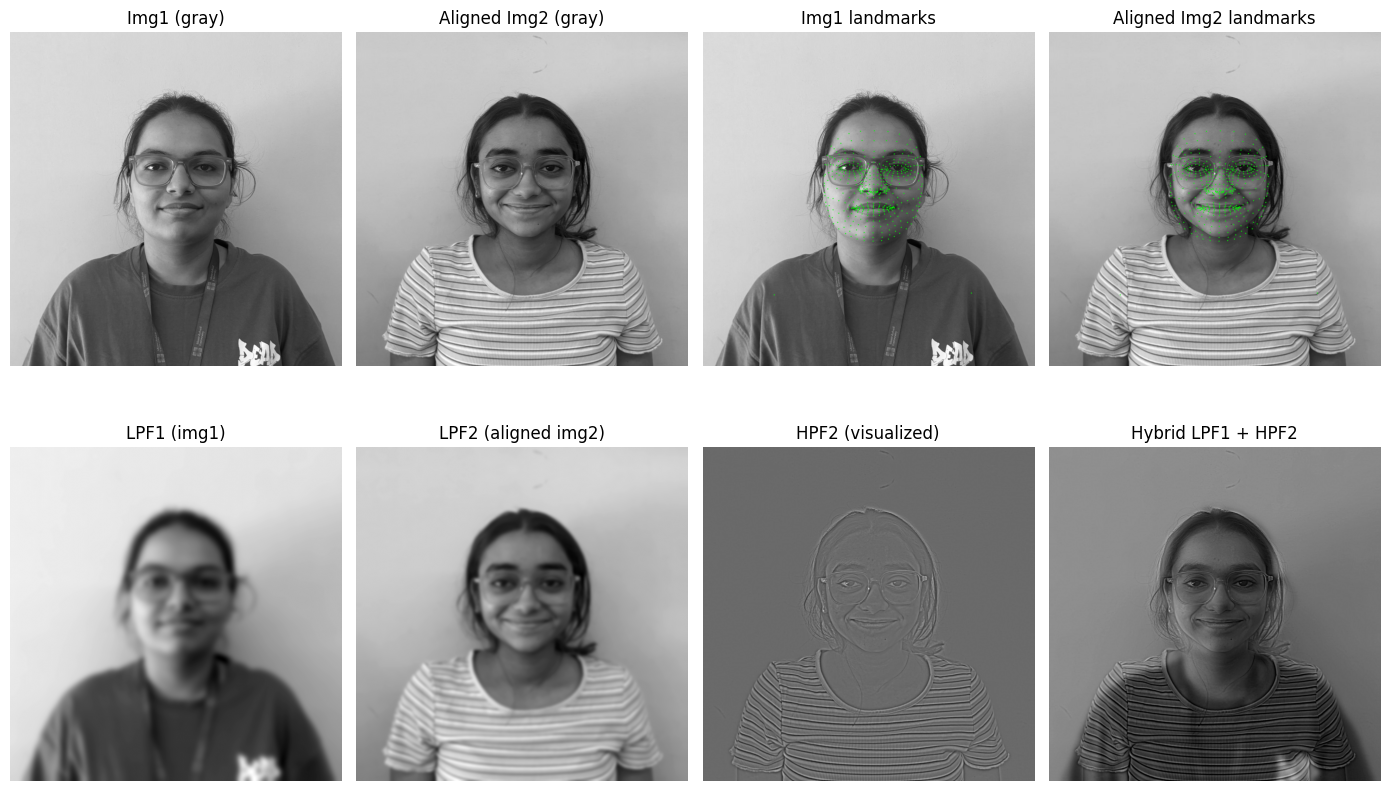

In [29]:
# Main
def main():
    try:
        img1_rgb = load_color(img1_path)
        img2_rgb = load_color(img2_path)
    except FileNotFoundError as e:
        print(e)
        print("Please make sure the image files exist at the specified paths.")
        return

    # Resize img2 to img1 size
    h, w = img1_rgb.shape[:2]
    img2_rgb = cv2.resize(img2_rgb, (w, h), interpolation=cv2.INTER_AREA)

    img1_gray = to_gray_uint8(img1_rgb)
    img2_gray = to_gray_uint8(img2_rgb)

    pts1 = extract_landmarks_combined(img1_rgb)
    pts2 = extract_landmarks_combined(img2_rgb)

    aligned2_rgb = None
    aligned2_gray = None

    # Try global registration using landmarks, If landmarks not usable, fallback to ORB+homography.
    if pts1 and pts2 and len(pts1) >= 6 and len(pts2) >= 6:
        print(f"Landmarks found: img1={len(pts1)} pts, img2={len(pts2)} pts -- estimating affine transform for registration.")
        common_len = min(len(pts1), len(pts2))
        src_pts = np.array(pts2[:common_len], dtype=np.float32)  # from img2
        dst_pts = np.array(pts1[:common_len], dtype=np.float32)  # to img1

        A, inliers = cv2.estimateAffinePartial2D(src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold=4.0, maxIters=2000)
        if A is not None:
            aligned2_rgb = cv2.warpAffine(img2_rgb, A, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
            aligned2_gray = to_gray_uint8(aligned2_rgb)
        else:
            print("Affine estimation failed; falling back to ORB + homography.")
    else:
        print("Not enough landmarks for global affine registration; attempting ORB + homography fallback.")

    if aligned2_gray is None:
        # Fallback to feature-based homography if registration failed
        orb = cv2.ORB_create(5000)
        kp1, des1 = orb.detectAndCompute(img1_gray, None)
        kp2, des2 = orb.detectAndCompute(img2_gray, None)
        if des1 is None or des2 is None or len(kp1) < 4 or len(kp2) < 4:
            raise RuntimeError("Feature detection failed; can't align images.")
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des1, des2)
        matches = sorted(matches, key=lambda x: x.distance)
        good = matches[: max(4, int(len(matches) * 0.2))]
        if len(good) < 4:
            raise RuntimeError("Not enough good matches for homography.")
        src_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
        dst_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        if H is None:
            raise RuntimeError("Homography estimation failed.")
        aligned2_rgb = cv2.warpPerspective(img2_rgb, H, (w,h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
        aligned2_gray = to_gray_uint8(aligned2_rgb)
        print("Aligned using homography fallback.")

    # At this point we have aligned2_gray aligned to img1 coordinate system.

    # Low-pass of image1 (LPF1) and low-pass of aligned image2 (LPF2)
    def low_gaussian(img, k=65):
        if k % 2 == 0: k += 1
        return cv2.GaussianBlur(img, (k,k), 0)
    LPF1 = low_gaussian(img1_gray, k=65)     # low-pass of Image 1
    LPF2 = low_gaussian(aligned2_gray, k=31) # low-pass of Image 2

    # High-pass of image 2: HPF2 = Original(aligned) - LPF2
    img2_f = aligned2_gray.astype(np.float32)
    LPF2_f = LPF2.astype(np.float32)
    HPF2_f = img2_f - LPF2_f   # signed high-frequency component

    # scale HPF2 (beta) and low-frequency (alpha)
    alpha = 0.6
    beta = 1.0

    # Compose hybrid in float, then clip & convert to uint8
    LPF1_f = LPF1.astype(np.float32)
    hybrid_f = alpha * LPF1_f + beta * HPF2_f
    hybrid_clipped = np.clip(hybrid_f, 0, 255).astype(np.uint8)

    # Save direct hybrid result
    cv2.imwrite("hybrid.jpg", hybrid_clipped)
    print("Saved hybrid.jpg")

    # Visualization
    def draw_points(img_gray, pts, radius=2):
        vis = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
        for (x,y) in pts:
            cv2.circle(vis, (int(x), int(y)), radius, (0,255,0), -1)
        return vis

    plt.figure(figsize=(14,9))
    plt.subplot(2,4,1); plt.imshow(img1_gray, cmap='gray'); plt.title("Img1 (gray)"); plt.axis('off')
    plt.subplot(2,4,2); plt.imshow(aligned2_gray, cmap='gray'); plt.title("Aligned Img2 (gray)"); plt.axis('off')
    try:
        plt.subplot(2,4,3); plt.imshow(draw_points(img1_gray, pts1)); plt.title("Img1 landmarks"); plt.axis('off')
    except:
        plt.subplot(2,4,3); plt.imshow(img1_gray, cmap='gray'); plt.title("Img1 landmarks (n/a)"); plt.axis('off')
    try:
        plt.subplot(2,4,4); plt.imshow(draw_points(aligned2_gray, pts1)); plt.title("Aligned Img2 landmarks"); plt.axis('off')
    except:
        plt.subplot(2,4,4); plt.imshow(aligned2_gray, cmap='gray'); plt.title("Aligned Img2"); plt.axis('off')

    plt.subplot(2,4,5); plt.imshow(LPF1, cmap='gray'); plt.title("LPF1 (img1)"); plt.axis('off')
    plt.subplot(2,4,6); plt.imshow(LPF2, cmap='gray'); plt.title("LPF2 (aligned img2)"); plt.axis('off')
    # show a scaled view of HPF2 (absolute) for visualization - normalize to 0..255
    hpvis = np.clip((HPF2_f - HPF2_f.min()) / (HPF2_f.max() - HPF2_f.min() + 1e-8) * 255, 0, 255).astype(np.uint8)
    plt.subplot(2,4,7); plt.imshow(hpvis, cmap='gray'); plt.title("HPF2 (visualized)"); plt.axis('off')
    plt.subplot(2,4,8); plt.imshow(hybrid_clipped, cmap='gray'); plt.title("Hybrid LPF1 + HPF2"); plt.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()